In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

action = np.load("actions/action-0-group-1-rec-1.npy")
action.shape

(450, 18, 3)

In [6]:
import glob

import numpy as np

def get_rows_for_file(file):
    data = np.load(file)
    nb_frames, nb_points, nb_values = data.shape

    res = np.empty((nb_frames, nb_points * nb_values + 1))

    # set features
    res[:,:-1] = data.reshape((nb_frames, nb_points * nb_values))

    # set labels
    parts = file.split('-')
    action_idx = int(parts[1])
    res[:,-1] = action_idx

    return res

In [7]:
Xy = np.vstack([get_rows_for_file(filename) for filename in glob.glob('actions/*group-[1-7]*.npy')])
Xy.shape

# 54 features and 1 label

(63000, 55)

In [8]:
X = Xy[:, :-1]
y = Xy[:, -1]

In [9]:
from sklearn.svm import LinearSVC


clf = LinearSVC(random_state=42)
clf.fit(X, y)

LinearSVC(random_state=42)

In [10]:
# predict the labels
_y = clf.predict(X)

In [11]:
from sklearn.metrics import accuracy_score

# calculate accuracy score for the data you used for training, this is not a good way!! :)
accuracy_score(y,_y)

0.8125238095238095

In [12]:
Xy_test = np.vstack([get_rows_for_file(names) for names in glob.glob('actions/*group-9*.npy')])
Xy_test.shape

(9450, 55)

In [13]:
X_test = Xy_test[:, :-1]
y_test = Xy_test[:, -1]

In [14]:
# predict the labels for the test data
_y_test = clf.predict(X_test)

accuracy_score(y_test,_y_test)

0.6466666666666666

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=42))

clf.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [16]:
accuracy_score(y, clf.predict(X))

0.8469047619047619

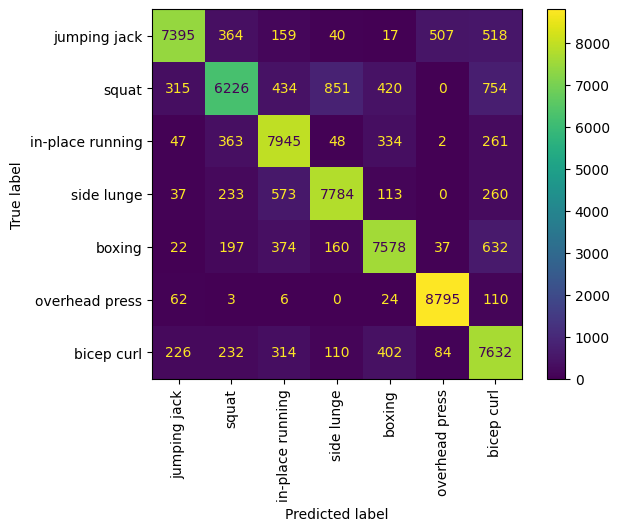

In [17]:
labels = [
    'jumping jack',
    'squat',
    'in-place running',
    'side lunge',
    'boxing',
    'overhead press',
    'bicep curl'
]

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    clf,X,y,display_labels=labels, xticks_rotation='vertical')

plt.show()

# overhead press is de meest duidelijke :) )